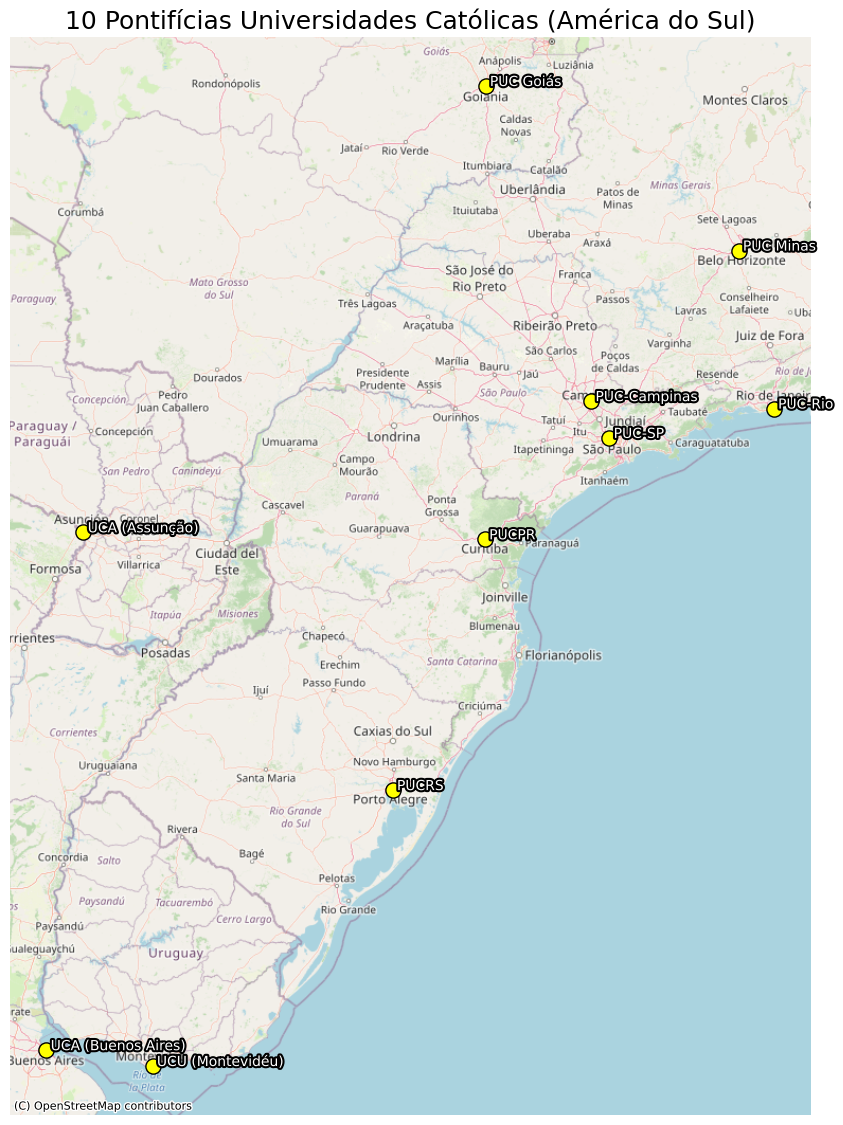

Iteração 10/200 | Melhor Distância: 5826.92
Iteração 20/200 | Melhor Distância: 5826.92
Iteração 30/200 | Melhor Distância: 5826.92
Iteração 40/200 | Melhor Distância: 5826.92
Iteração 50/200 | Melhor Distância: 5826.92
Iteração 60/200 | Melhor Distância: 5826.92
Iteração 70/200 | Melhor Distância: 5826.92
Iteração 80/200 | Melhor Distância: 5826.92
Iteração 90/200 | Melhor Distância: 5826.92
Iteração 100/200 | Melhor Distância: 5826.92
Iteração 110/200 | Melhor Distância: 5826.92
Iteração 120/200 | Melhor Distância: 5826.92
Iteração 130/200 | Melhor Distância: 5826.92
Iteração 140/200 | Melhor Distância: 5826.92
Iteração 150/200 | Melhor Distância: 5826.92
Iteração 160/200 | Melhor Distância: 5826.92
Iteração 170/200 | Melhor Distância: 5826.92
Iteração 180/200 | Melhor Distância: 5826.92
Iteração 190/200 | Melhor Distância: 5826.92
Iteração 200/200 | Melhor Distância: 5826.92

Distância do melhor caminho: 5826.92
Tempo de execução: 4.55 segundos



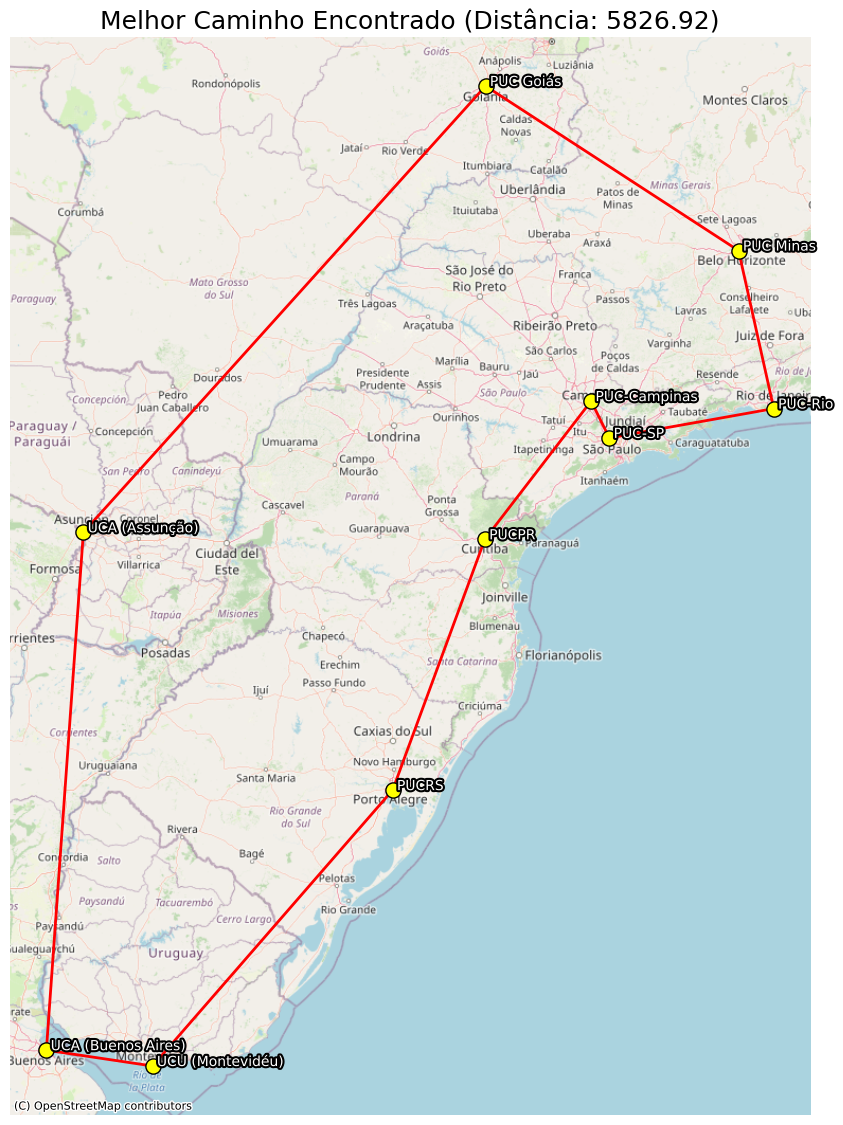

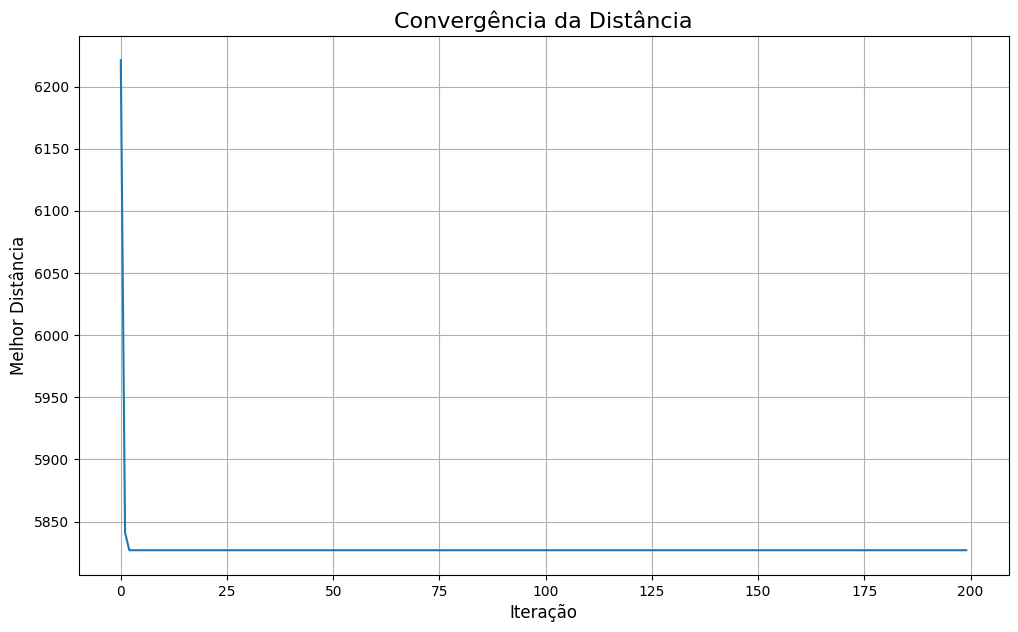

In [5]:
# ==============================================================================
# INSTRUÇÕES PARA O GOOGLE COLAB:
# Basta colar este código em uma célula e executá-lo.
# Ele instalará automaticamente as bibliotecas necessárias.
# ==============================================================================

# --- 0. Instalação das Bibliotecas ---
# A instalação só é necessária na primeira vez que você roda o notebook.
try:
    import geopandas
    import contextily
except ImportError:
    print("Instalando bibliotecas geoespaciais, por favor aguarde...")
    import sys
    !{sys.executable} -m pip install geopandas contextily &> /dev/null
    print("Instalação concluída.")

import numpy as np
import matplotlib.pyplot as plt
import random
import math
import time
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point, LineString
import matplotlib.patheffects as pe

# --- 1. Definição dos Pontos (Universidades) ---
puc_locations = {
    "PUC Minas": (-43.9903, -19.9233),
    "PUC-Rio": (-43.2598, -22.9757),
    "PUC-SP": (-46.6738, -23.5354),
    "PUC-Campinas": (-47.0521, -22.8329),
    "PUCPR": (-49.2592, -25.4515),
    "PUCRS": (-51.1738, -30.0577),
    "PUC Goiás": (-49.2444, -16.6786),
    "UCA (Assunção)": (-57.5951, -25.3202),
    "UCA (Buenos Aires)": (-58.3639, -34.6186),
    "UCU (Montevidéu)": (-56.1589, -34.8886)
}
cities = list(puc_locations.items())

# --- 2. Funções de Distância ---
def distance(city1, city2):
    _, (x1, y1) = city1
    _, (x2, y2) = city2
    # Aproximação para converter graus em "distância" para o algoritmo.
    return math.sqrt(((x1 - x2) * 111)**2 + ((y1 - y2)*111)**2)

def path_distance(path):
    total_dist = 0
    if not path or len(path) < 2: return 0
    for i in range(len(path) - 1):
        total_dist += distance(path[i], path[i+1])
    total_dist += distance(path[-1], path[0])
    return total_dist

# --- 3. Classe da Colônia de Formigas (Mesma lógica de antes) ---
class AntColonySolver:
    def __init__(self, cost_fn, ant_count=50, iterations=200,
                 distance_power=1.0, pheromone_power=1.25, decay_power=0.1,
                 reward_power=1.0, best_path_smell=2.0, max_pheromone=100.0):
        self.cost_fn = cost_fn
        self.ant_count = ant_count
        self.iterations = iterations
        self.distance_power = distance_power
        self.pheromone_power = pheromone_power
        self.decay_power = decay_power
        self.reward_power = reward_power
        self.best_path_smell = best_path_smell
        self.max_pheromone = max_pheromone

        self._initialized = False
        self.best_path_ = None
        self.best_path_cost_ = float('inf')
        self.history_ = []

    def _initialize(self, problem_path):
        self.nodes = problem_path
        self.node_indices = {node[0]: i for i, node in enumerate(self.nodes)}
        num_nodes = len(self.nodes)

        self.distances = np.zeros((num_nodes, num_nodes))
        for i in range(num_nodes):
            for j in range(i + 1, num_nodes):
                dist = self.cost_fn(self.nodes[i], self.nodes[j])
                self.distances[i, j] = self.distances[j, i] = dist

        with np.errstate(divide='ignore'):
            self.distance_cost = (1.0 / self.distances) ** self.distance_power

        self.pheromones = np.ones((num_nodes, num_nodes))
        self._initialized = True

    def _choose_next_node(self, current_node_idx, visited_mask):
        epsilon = 1e-10
        pheromone_slice = (self.pheromones[current_node_idx, :] + epsilon) ** self.pheromone_power
        distance_slice = self.distance_cost[current_node_idx, :]
        probabilities = pheromone_slice * distance_slice
        probabilities[visited_mask] = 0
        total_prob = np.sum(probabilities)

        if total_prob == 0:
            unvisited_indices = np.where(~visited_mask)[0]
            return np.random.choice(unvisited_indices) if len(unvisited_indices) > 0 else -1

        probabilities /= total_prob
        return np.random.choice(range(len(self.nodes)), p=probabilities)

    def _update_pheromones(self, all_paths):
        self.pheromones *= (1.0 - self.decay_power)
        for path, cost in all_paths:
            if cost == 0: continue
            reward = (self.best_path_cost_ / cost) ** self.reward_power
            for i in range(len(path) - 1):
                idx1, idx2 = self.node_indices[path[i][0]], self.node_indices[path[i+1][0]]
                self.pheromones[idx1, idx2] += reward
                self.pheromones[idx2, idx1] += reward
            if path == self.best_path_:
                for i in range(len(path) - 1):
                    idx1, idx2 = self.node_indices[path[i][0]], self.node_indices[path[i+1][0]]
                    self.pheromones[idx1, idx2] *= self.best_path_smell
                    self.pheromones[idx2, idx1] *= self.best_path_smell
        self.pheromones = np.clip(self.pheromones, 0, self.max_pheromone)

    def solve(self, problem_path):
        if not self._initialized: self._initialize(problem_path)
        num_nodes = len(self.nodes)
        for iteration in range(self.iterations):
            all_paths = []
            for _ in range(self.ant_count):
                start_node_idx = random.randint(0, num_nodes - 1)
                path_indices = [start_node_idx]
                visited_mask = np.zeros(num_nodes, dtype=bool)
                visited_mask[start_node_idx] = True
                while len(path_indices) < num_nodes:
                    next_node_idx = self._choose_next_node(path_indices[-1], visited_mask)
                    if next_node_idx == -1: break
                    path_indices.append(next_node_idx)
                    visited_mask[next_node_idx] = True

                path = [self.nodes[i] for i in path_indices]
                cost = path_distance(path)
                all_paths.append((path, cost))
                if cost < self.best_path_cost_:
                    self.best_path_cost_, self.best_path_ = cost, path

            self._update_pheromones(all_paths)
            self.history_.append(self.best_path_cost_)
            if (iteration + 1) % 10 == 0:
                print(f"Iteração {iteration + 1}/{self.iterations} | Melhor Distância: {self.best_path_cost_:.2f}")
        return self.best_path_

# --- 4. Funções de Visualização (Geoespacial) ---
def plot_geospatial(cities, path=None, title=""):
    """Plota as cidades e o caminho sobre um mapa real."""
    # Converte os pontos para um formato geoespacial
    gdf_points = gpd.GeoDataFrame(
        [city[0] for city in cities],
        geometry=[Point(city[1]) for city in cities],
        columns=['Name']
    )
    gdf_points.set_crs(epsg=4326, inplace=True) # Define o sistema de coordenadas (Lat/Lon)

    # Cria o gráfico
    ax = gdf_points.to_crs(epsg=3857).plot(figsize=(14, 14), color='yellow', edgecolor='black', markersize=120, zorder=3)

    # Adiciona os rótulos aos pontos
    for idx, row in gdf_points.to_crs(epsg=3857).iterrows():
        ax.text(row.geometry.x + 10000, row.geometry.y, row['Name'], fontsize=10,
                path_effects=[pe.withStroke(linewidth=3, foreground="black")], color='white')

    # Plota a rota se existir
    if path:
        path_points = [Point(city[1]) for city in path]
        if path_points:
            path_points.append(path_points[0]) # Fecha o ciclo
            line = LineString(path_points)
            gdf_path = gpd.GeoDataFrame(geometry=[line], crs="EPSG:4326")
            gdf_path.to_crs(epsg=3857).plot(ax=ax, color='red', linewidth=2, zorder=2)

    # Adiciona o mapa de fundo
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

    ax.set_title(title, fontsize=18)
    ax.set_axis_off() # Remove os eixos X e Y
    plt.show()

def plot_history(history):
    plt.figure(figsize=(12, 7))
    plt.plot(history)
    plt.title("Convergência da Distância", fontsize=16)
    plt.xlabel("Iteração", fontsize=12)
    plt.ylabel("Melhor Distância", fontsize=12)
    plt.grid(True)
    plt.show()

# --- 5. Execução Principal ---
if __name__ == '__main__':
    NUM_ANTS = 50
    NUM_ITERATIONS = 200
    DISTANCE_POWER = 1.0
    PHEROMONE_POWER = 3.0
    DECAY_POWER = 0.1

    # Plot inicial (sem rota)
    plot_geospatial(cities, title="10 Pontifícias Universidades Católicas (América do Sul)")

    # Executa o algoritmo
    solver = AntColonySolver(cost_fn=distance, ant_count=NUM_ANTS, iterations=NUM_ITERATIONS,
                             distance_power=DISTANCE_POWER, pheromone_power=PHEROMONE_POWER,
                             decay_power=DECAY_POWER)
    start_time = time.time()
    best_path = solver.solve(cities)
    end_time = time.time()

    # Exibe resultados
    print(f"\nDistância do melhor caminho: {solver.best_path_cost_:.2f}")
    print(f"Tempo de execução: {end_time - start_time:.2f} segundos\n")

    # Plot final (com a melhor rota) e gráfico de convergência
    plot_geospatial(best_path, path=best_path, title=f"Melhor Caminho Encontrado (Distância: {solver.best_path_cost_:.2f})")
    plot_history(solver.history_)